# Reinforcement learning model explanations with SHAP #

## Imports, loads and data processing functions ##

In [1]:
import pickle
import gym
import pandas as pd
import numpy as np
import os
import shap
import warnings

from stable_baselines3 import PPO
from stable_baselines3.common.policies import obs_as_tensor

warnings.filterwarnings("ignore")

In [2]:
file_path = './final_ipynb/'

In [3]:
x_train_df = pd.read_csv(file_path+'x_train.csv')
x_train = x_train_df.values

x_test_df = pd.read_csv(file_path+'test_alldata_EDA.csv')

del x_train_df

In [4]:
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"None" if x=="-" else x)

        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

In [5]:
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

In [6]:
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

In [7]:
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''

    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [8]:
# Parametrs
saved_dict = pickle.load(open(file_path+'saved_dict.pkl', 'rb'))
# Mode value of all the columns
mode_dict = pickle.load(open(file_path+'mode_dict.pkl', 'rb'))
# Stanardscaler object
scaler = pickle.load(open(file_path+'scaler.pkl', 'rb'))
# One hot encoder objects
ohe_proto = pickle.load(open(file_path+'ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'ohe_state.pkl', 'rb'))

## Auxiliary: in case you want to get anomalies indexes ##

In [9]:
y_test = x_test_df['label']

att_idx = []
for idx, _ in enumerate(y_test):
    if y_test[idx] != 0:
        att_idx.append(idx)

In [10]:
att_idx[:15]

[53, 54, 97, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]

## Generate a SHAP waterfall graph as an explanation ##

In [11]:
def generateFixedExplanation(sample, explainer, cleaned_cols, processed_cols):
    shap_values = explainer.shap_values(sample, normalize=False)
    new_values = []
    
    # Sums of X_proto columns and similar 
    for f in cleaned_cols:
        tmp = 0
        for idx, p in enumerate(processed_cols):
            if p.startswith(f):
                tmp += shap_values[idx]
        new_values.append(tmp)
        
    new_values = np.asarray(new_values, np.float32)
    
    exp = shap.Explanation(new_values, 
                           SHAP_explainer.expected_value, 
                           data=x_test_original.iloc[0].values, 
                           feature_names=clean_cols)
    
    shap.plots.waterfall(exp, max_display=10)

### Reinforcement Model load and SHAP Kernel Explainer initialisation ###

In [12]:
test_model = PPO.load('./Models/PPO')

SHAP_explainer = shap.KernelExplainer(lambda x: test_model.predict(x)[0], 
                                      shap.sample(x_train, 100))

### Sample selection and processing, original value and columns copy  ###

In [13]:
# Sample selection
sample_idx = 118
sample_df = x_test_df.drop(columns=['label']).iloc[[sample_idx]]
sample_df.reset_index(drop=True, inplace=True)

# Performs a clean on the sample
dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
sample_df.drop(columns=dropable_col, inplace=True)
sample_df = clean_data(sample_df)

In [14]:
# If you wish to change the sample data, change it here. Examples:
# sample_df['ct_state_ttl'] = 0
# sample_df['dur'] = 9999999999999999
# sample_df['dttl'] = 0

display(sample_df.iloc[0])

proto                       tcp
state                       FIN
dur                    0.841873
sbytes                      564
dbytes                      354
sttl                        254
dttl                        252
sloss                         2
service                    None
sload               4827.331543
dload                 2945.8125
spkts                        10
swin                        255
stcpb                3240426617
dtcpb                1691987323
smeansz                      56
dmeansz                      44
trans_depth                   0
res_bdy_len                   0
sjit                6529.280566
djit                 164.364563
stime                1424247760
sintpkt               93.541444
dintpkt              108.679859
tcprtt                 0.159898
synack                 0.080401
ackdat                 0.079497
is_sm_ips_ports               0
ct_state_ttl                  1
ct_flw_http_mthd            0.0
is_ftp_login                0.0
ct_ftp_c

In [15]:
# Add the aditional network_bytes column
sample_df['network_bytes'] = sample_df['dbytes'] + sample_df['sbytes']

# Copies the original values values and columns for later use on explanations
x_test_original = sample_df.copy()
clean_cols = sample_df.columns.values # 39 features

In [16]:
# Processes the sample and also saves the processed column names
sample_df = apply_log1p(sample_df)
sample_df = standardize(sample_df)
sample_df = ohencoding(sample_df)
processed_cols = sample_df.columns.values # 200 features

# Get the values of the processed sample as an array
sample = sample_df.iloc[0].values

### Visual explanation ###

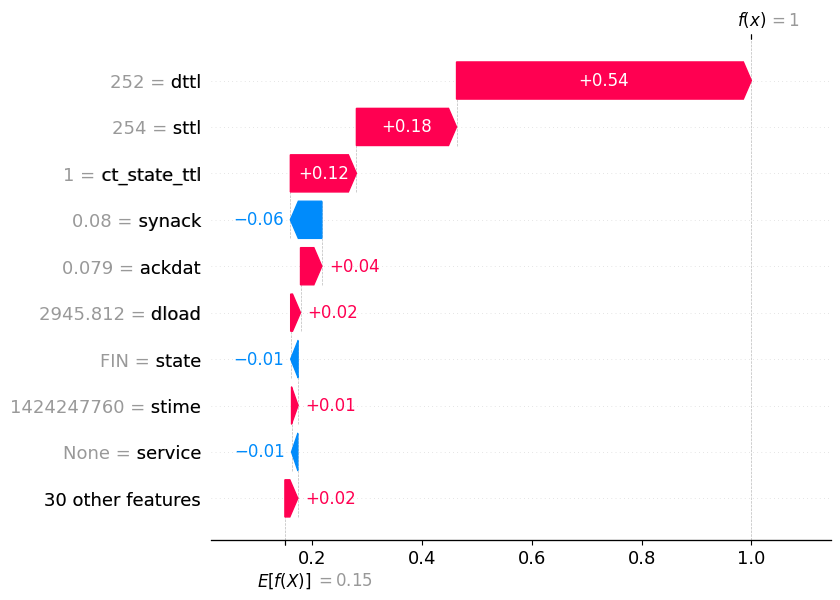

In [17]:
generateFixedExplanation(sample=sample,
                         explainer=SHAP_explainer,
                         cleaned_cols=clean_cols,
                         processed_cols=processed_cols)